<a href="https://www.kaggle.com/rsizem2/tps-02-22-data-augmentation?scriptVersionId=88753117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Augmentation

In this notebook, we use knowledge about how our data was generated to augment or create new training samples. This data is then combined with the original data to see if we can improve our CV or test results.

## Original Data Generation

From the description in the original paper, each training example consists of length 10 samples of the full bacterial DNA gotten by the following process:

$$\cdots \text{ATCG}\textbf{CTGGATAGCA}\text{TACG} \cdots \xrightarrow{sample} \text{CTGGATAGCA} \xrightarrow{bin} A_3T_2G_3C_2$$

Each training example consists of either 1 million, 100k, 1k or 100 length 10 reads, which are then turned into a probability distribution and altered by subtracting off the bias distribution (expected distribution of randomly generated DNA sequences). We refer to the subset of data generated from 1 million or 100k reads as the **high resolution data** and the subset generated by 1000 or 100 reads as the **low resolution data**. With some work, we can retrieve (a constant multiple of) the original samples from the provided training data and we distinguish each subset by the GCD of the samples.

## Augmentation/Resampling

We can predict almost perfectly on the high resolution data and with varying results on the low resolution data. So we will focus on the low resolution data, we will use two main two approaches.

The first approach we will augment training examples. Recall that each low resolution training example consists 100 or 1000 DNA samples. We augment a data point by replace a fraction of these samples with new samples from the same (or approximately the same) distribution, or by replacing them with randomly generated DNA samples (this can be thought of as sampling error). The second approach we will create brand new low resolution training examples using the high resolution data to approximate the original DNA. In particular, we will try the following:

1. Simulate errors by replacing samples with completely random DNA reads
2. Augment low resolution data with samples taken from high resolution *training* data
3. Augment low resolution data with samples taken from high resolution *test* data
4. Create new low resolution data by sampling from high resolution *training* data
5. Create new low resolution data by sampling from high resolution *test* data

I will update successive versions of this notebook with the resulting public leaderboard scores for each experiment.

**Credits:** The idea for this notebook and a few of these helper functions I used are adapted from [this great notebook](https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/).

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 99
NUM_FOLDS = 10
ALTER_RATE = 0.2
EXT_PARAMS = dict(n_estimators = 300, random_state = RANDOM_SEED, n_jobs = -1)

In [2]:
# Generic
import numpy as np
import pandas as pd
import pyarrow
import time
import gc

# Sklearn
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

# Other stuff
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product
from scipy.stats import mode
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
from tqdm import tqdm

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Preliminaries

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

# Convert to integer histograms
def get_histograms(input_df):
    return pd.DataFrame({col: ((input_df[col] + BIAS[col]) * 1000000).round().astype(int) for col in features})

# Finds GCD of each row, assumes integer histograms
def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

# Create a new dataframe without duplicates, but with an additional sample_weight column
def remove_duplicates(input_df):
    vc = input_df.value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df.columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

# Function for downcasting float/int datatypes
def reduce_memory_usage(path):
    df = pd.read_csv(path);
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
    return df

# Convert deviation spectrum to raw histograms
def convert_to_histograms(input_df):
    temp = pd.DataFrame({
        col: ((input_df[col] + BIAS[col]) * 1000000).round().astype(int) for col in features
    })
    temp['gcd'] = input_df['gcd']
    for col in features:
        temp[col] //= temp['gcd']
    return temp

# Create Counters from integer histograms
def make_counters(input_df):
    samples, gcd, labels = list(), list(), list()
    for (index, row), dupes, val, label in zip(input_df[features].iterrows(), input_df['sample_weight'], input_df['gcd'], input_df['target']):
        sample = row.to_dict()
        for _ in range(dupes):
            gcd.append(val)
            labels.append(label)
            samples.append(Counter(sample))
    return samples, gcd, labels

# Convert raw histograms to deviation spectrum
def normalize_histograms(input_df):
    temp = input_df.copy()
    for col in features:
        temp[col] *= temp['gcd']
        temp[col] /= 1000000
        temp[col] -= BIAS[col]
    return input_df

## Load Data

We save the preprocessed data locally in feather format to speedup successive runs of this notebook.

In [4]:
%%time

try:
    train = pd.read_feather('train.feather')
    test = pd.read_feather('test.feather')
    features = [x for x in train.columns if x not in ['row_id','target','gcd','sample_weight']]
    BIAS = {x: bias_of(x) for x in features}
    submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')
except:
    train = reduce_memory_usage('../input/tabular-playground-series-feb-2022/train.csv')
    train.drop(columns='row_id', inplace = True)
    features = [x for x in train.columns if x not in ['row_id','target','gcd']]
    BIAS = {x: bias_of(x) for x in features}
    train = remove_duplicates(train)
    train['gcd'] = gcd_of_all(get_histograms(train[features]))
    train.to_feather('train.feather')
    test = reduce_memory_usage('../input/tabular-playground-series-feb-2022/test.csv')
    test.drop(columns='row_id', inplace = True)
    test['gcd'] = gcd_of_all(get_histograms(test[features]))
    test.to_feather('test.feather')
    submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')
    
# Labels encoding
encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])

# Stratified K-fold
target_bins = train['target'].astype(str) + train['gcd'].astype(str)
SKF = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: user 1min 7s, sys: 16.8 s, total: 1min 24s
Wall time: 1min 36s


## Scoring/Evaluation

We ensemble our predictions with both hard and soft voting as well as return the out-of-fold predictions on the training data so we can do error analysis.

In [5]:
# Scoring/Training Baseline Function
def score_model(sklearn_model):
    
    # Store the holdout predictions
    oof_preds = np.zeros((len(train),))
    test_proba = np.zeros((len(test),len(train['target'].unique())))
    test_preds = list()
    scores = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    for fold, (train_idx, valid_idx) in enumerate(SKF.split(train, target_bins)):
        
        # Train/Test/Validation Sets
        X_train, y_train = train[features + ['gcd']].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features + ['gcd']].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weights, valid_weights = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
        X_test = test[features + ['gcd']]; start = time.time()
        
        # Train Model
        model = clone(sklearn_model)
        model.fit(X_train, y_train, sample_weight = train_weights)
        gc.collect()
        
        # Get Predictions
        valid_preds = np.argmax(model.predict_proba(X_valid), axis = 1)
        test_prob = model.predict_proba(X_test)
        
        # Save Predictions
        test_proba += test_prob / NUM_FOLDS
        test_preds.append(np.argmax(test_prob, axis = 1))
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weights)
        oof_preds[valid_idx] = valid_preds
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(time.time()-start,2)}s.')
    
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    return oof_preds, np.argmax(test_proba, axis = 1), mode(test_preds).mode[0]

In [6]:
# Confusion Matrix Plotting
def plot_confusion_matrix(true_values, pred_values, gcds, sample_weight = None, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Create plot for each data resolution
    fig, ax = plt.subplots(2, 2, figsize = (12,10))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            if sample_weight is not None:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]], sample_weight = sample_weight[gcds == gcd[row][col]])
            else:
                cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
                acc = accuracy_score(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
            ax[row,col].set_title(f'GCD = {gcd[row][col]}, Accuracy: {round(acc, 5)}')
    plt.show()

## Model

The model we use is based on [my previous notebook](https://www.kaggle.com/rsizem2/tps-02-22-separating-high-low-resolution-data), and trains a separate `ExtraTreesClassifier` on each subset of the data (based on resolution).

In [7]:
class FourResolutions(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 1,000,000 BOC Reads
        self.model2 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 100,000 BOC Reads
        self.model3 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 1,000 BOC Reads
        self.model4 = ExtraTreesClassifier(**EXT_PARAMS) # Model for 100 BOC Reads
        
    def get_gcds(self, X):
        self.gcd1 = (X.gcd == 1)
        self.gcd2 = (X.gcd == 10)
        self.gcd3 = (X.gcd == 1000)
        self.gcd4 = (X.gcd == 10000)
    
    def fit(self, X, y, sample_weight = None):
        self.get_gcds(X)
        self.num_labels = len(np.unique(y))
        if sample_weight is not None:
            self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
            self.model3.fit(X[self.gcd3], y[self.gcd3], sample_weight[self.gcd3])
            self.model4.fit(X[self.gcd4], y[self.gcd4], sample_weight[self.gcd4])
        else:
            self.model1.fit(X[self.gcd1], y[self.gcd1])
            self.model2.fit(X[self.gcd2], y[self.gcd2])
            self.model3.fit(X[self.gcd3], y[self.gcd3])
            self.model4.fit(X[self.gcd4], y[self.gcd4])
            
    def predict_proba(self, X):
        self.get_gcds(X)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict_proba(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict_proba(X[self.gcd4])
        return temp
        
    def predict(self, X):
        self.get_gcds(X)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict(X[self.gcd4])
        return temp.astype(int)

# Baseline

Training on the original dataset with no modifications


Fold 0: 0.95633 accuracy in 33.98s.
Fold 1: 0.95549 accuracy in 34.33s.
Fold 2: 0.9536 accuracy in 33.64s.
Fold 3: 0.95316 accuracy in 33.63s.
Fold 4: 0.95796 accuracy in 35.12s.
Fold 5: 0.95534 accuracy in 33.43s.
Fold 6: 0.95824 accuracy in 32.83s.
Fold 7: 0.95749 accuracy in 33.58s.
Fold 8: 0.9575 accuracy in 33.05s.
Fold 9: 0.9531 accuracy in 32.92s.

Average Accuracy: 0.95582


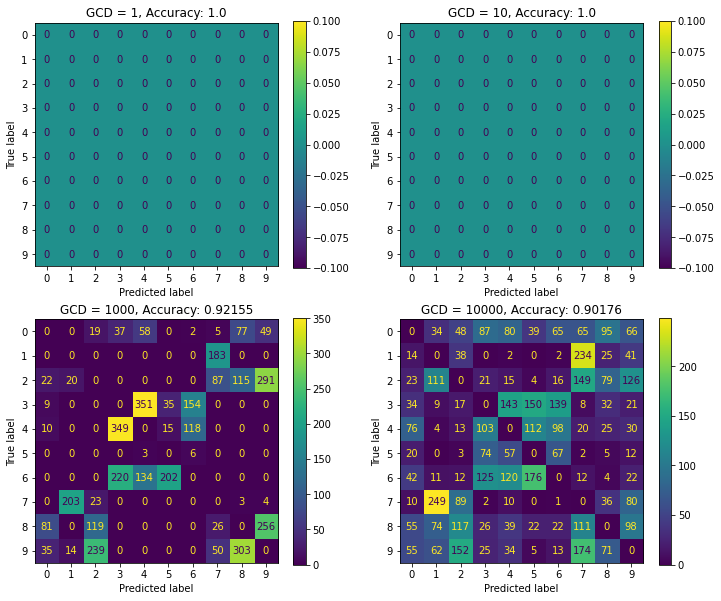

In [8]:
oof_preds, test_soft, test_hard = score_model(
    FourResolutions()
)

# Save Predictions 
test['target'] = test_hard

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# Sample Distributions

The following functions create the probability distributions which we'll use to create new DNA reads with which we'll augment our data or create all new training samples.

In [9]:
def get_distributions(input_df):
    
    # Only use highest resolution samples
    temp = convert_to_histograms(input_df)
    temp['target'] = input_df['target'].values
    temp = temp[temp.gcd == 1].reset_index(drop=True)
    
    # Get sample distributions for each bacteria
    dist = dict()
    for label in np.unique(temp['target']):
        temp_vec = np.sum(temp[temp.target == label][features], axis = 0) 
        dist[label] = temp_vec / np.sum(temp_vec)
    return dist

In [10]:
RANDOM_DIST = [bias_of(x) for x in features]
TRAIN_DIST = get_distributions(train)
TEST_DIST = get_distributions(test)

# Experiment 1: Error Simulation

In our first experiment, for each training example we replace a fraction of the original DNA reads with completely random DNA reads. 

In [11]:
# Error Simulation
class ErrorSimulator(BaseEstimator):
    
    def __init__(self, error_rate = 0.1):
        
        self.model = FourResolutions()
        self.rng = np.random.default_rng()
        self.error_rate = error_rate
        
    def fit(self, X, y, sample_weight = None):
        
        # Get original histograms and convert to Counters
        new_samples = convert_to_histograms(X)
        new_samples['target'] = y.values
        new_samples['sample_weight'] = sample_weight.values
        new_samples = new_samples[new_samples.gcd > 100].reset_index(drop = True)
        new_samples, gcd, labels = make_counters(new_samples)
        gc.collect()
        
        # Simulate errors 
        for val, sample in zip(gcd, new_samples):
            num_errors = self.rng.binomial(n = 1000000 // val, p = self.error_rate)
            old_reads = self.rng.choice(list(sample.elements()), size = num_errors, replace = False)
            new_reads = self.rng.choice(features, size = len(old_reads), p = RANDOM_DIST, replace = True)
            sample.subtract(old_reads)
            sample.update(new_reads)
        new_samples = pd.DataFrame.from_records(new_samples, columns = features).fillna(0).astype(int)
        new_samples['target'] = labels
        new_samples['gcd'] = gcd
        new_samples = new_samples.sample(frac=1).reset_index(drop=True); gc.collect()
        new_samples = remove_duplicates(normalize_histograms(new_samples))
        
        # Duplicate original data and combine with altered samples 
        original = X.reset_index(drop = True)
        original['target'] = y.values
        original['sample_weight'] = sample_weight.values
        new_samples = pd.concat([original, new_samples], ignore_index = True).sample(frac=1).reset_index(drop=True)
        
        # Fit model
        self.model.fit(new_samples[features + ['gcd']], new_samples['target'], sample_weight = new_samples['sample_weight'])
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)


Fold 0: 0.95534 accuracy in 234.53s.
Fold 1: 0.95615 accuracy in 232.45s.
Fold 2: 0.95485 accuracy in 228.43s.
Fold 3: 0.95474 accuracy in 229.4s.
Fold 4: 0.95697 accuracy in 229.2s.
Fold 5: 0.95529 accuracy in 229.17s.
Fold 6: 0.96035 accuracy in 229.64s.
Fold 7: 0.96278 accuracy in 228.39s.
Fold 8: 0.9569 accuracy in 229.0s.
Fold 9: 0.95551 accuracy in 228.04s.

Average Accuracy: 0.95689


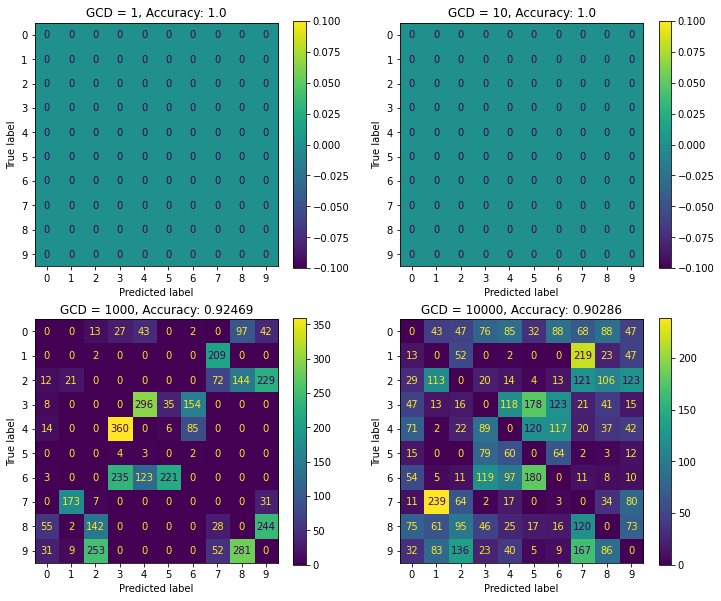

In [12]:
oof_preds, test_soft, test_hard = score_model(
    ErrorSimulator(
        error_rate = ALTER_RATE
    )
)

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('random_error_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('random_error_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# Experiment 2: Data Augmentation

In our second experiment, for each training example we replace a fraction of the original DNA reads with new DNA reads generated using the high resolution data as an approximation of the original target bacteria DNA. 

In [13]:
# Augment data with reads from 
class DataAugmentation(BaseEstimator):
    
    def __init__(self, augment_rate = 0.1, test_samples = False):
        
        self.model = FourResolutions()
        self.rng = np.random.default_rng()
        self.augment_rate = augment_rate
        self.test_samples = test_samples
        
    def fit(self, X, y, sample_weight = None):
        
        # Get original histograms
        new_samples = convert_to_histograms(X)
        new_samples['target'] = y.values
        new_samples['sample_weight'] = sample_weight.values
        new_samples = new_samples[new_samples.gcd > 100].reset_index(drop = True)
        new_samples, gcd, labels = make_counters(new_samples)
        gc.collect()
        
        # Replace with alternate samples
        for val, label, sample in zip(gcd, labels, new_samples):
            num_errors = self.rng.binomial(n = 1000000 // val, p = self.augment_rate)
            old_reads = self.rng.choice(list(sample.elements()), size = num_errors, replace = False)
            if self.test_samples:
                new_reads = self.rng.choice(features, size = len(old_reads), p = TEST_DIST[label], replace = True)
            else:
                new_reads = self.rng.choice(features, size = len(old_reads), p = TRAIN_DIST[label], replace = True)
            sample.subtract(old_reads)
            sample.update(new_reads)
        new_samples = pd.DataFrame.from_records(new_samples, columns = features).fillna(0).astype(int)
        new_samples['target'] = labels
        new_samples['gcd'] = gcd
        new_samples = new_samples.sample(frac=1).reset_index(drop=True); gc.collect()
        new_samples = remove_duplicates(normalize_histograms(new_samples))
        
        # Duplicate original data and combine with altered samples 
        original = X.reset_index(drop = True)
        original['target'] = y.values
        original['sample_weight'] = sample_weight.values
        new_samples = pd.concat([original, new_samples], ignore_index = True).sample(frac=1).reset_index(drop=True)
        
        # Fit model
        self.model.fit(new_samples[features + ['gcd']], new_samples['target'], sample_weight = new_samples['sample_weight'])
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)

## Sample Using Train Data


Fold 0: 0.95748 accuracy in 223.44s.
Fold 1: 0.95786 accuracy in 232.82s.
Fold 2: 0.9559 accuracy in 226.67s.
Fold 3: 0.95603 accuracy in 216.52s.
Fold 4: 0.96157 accuracy in 224.78s.
Fold 5: 0.95569 accuracy in 225.82s.
Fold 6: 0.95834 accuracy in 226.31s.
Fold 7: 0.96157 accuracy in 225.19s.
Fold 8: 0.9576 accuracy in 224.59s.
Fold 9: 0.95576 accuracy in 224.37s.

Average Accuracy: 0.95778


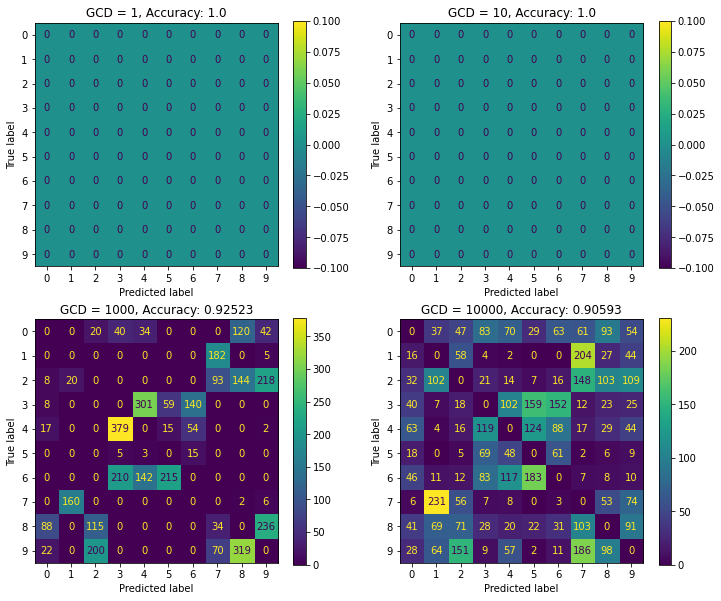

In [14]:
oof_preds, test_soft, test_hard = score_model(
    DataAugmentation(
        augment_rate = ALTER_RATE,
        test_samples = False
    )
)

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('augment_train_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('augment_train_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## Sample Using Test Data


Fold 0: 0.95932 accuracy in 229.83s.
Fold 1: 0.95735 accuracy in 224.71s.
Fold 2: 0.9576 accuracy in 228.54s.
Fold 3: 0.95782 accuracy in 224.88s.
Fold 4: 0.959 accuracy in 224.33s.
Fold 5: 0.95334 accuracy in 227.56s.
Fold 6: 0.95799 accuracy in 221.58s.
Fold 7: 0.96162 accuracy in 215.59s.
Fold 8: 0.95535 accuracy in 220.44s.
Fold 9: 0.95195 accuracy in 220.52s.

Average Accuracy: 0.95713


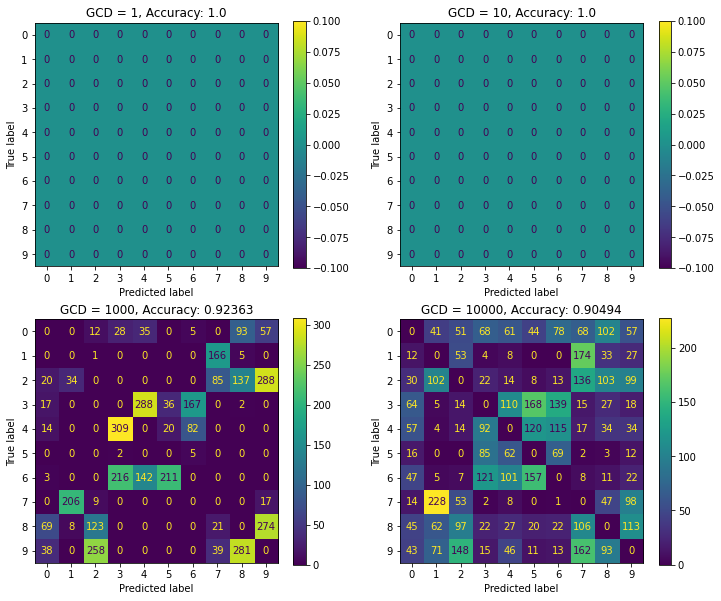

In [15]:
oof_preds, test_soft, test_hard = score_model(
    DataAugmentation(
        augment_rate = ALTER_RATE,
        test_samples = True
    )
)

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('augment_test_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('augment_test_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

# Experiment 3: Resampling

Our final experiment, we will make entirely new training data (instead of altering existing data) using the sample distributions generated from the high resolution data.

In [16]:
# Augment data with reads from 
class Resampler(BaseEstimator):
    
    def __init__(self, test_samples = False):
        
        self.model = FourResolutions()
        self.rng = np.random.default_rng()
        self.test_samples = test_samples
        
    def fit(self, X, y, sample_weight = None):
        
        
        # Total new samples
        num_samples = len(X)
        num_samples //= 2
        num_samples //= len(np.unique(y))
        new_samples, gcd, labels = list(), list(), list()
        gc.collect()
        
        # Replace with alternate samples
        for val in [1000, 10000]:
            for label in np.unique(y):
                for _ in range(num_samples):
                    num_reads = 1000000 // val
                    if self.test_samples:
                        temp = Counter(
                            self.rng.choice(
                                features, 
                                size = 1000000 // val, 
                                p = TEST_DIST[label], 
                                replace = True
                            )
                        )
                    else:
                        temp = Counter(
                            self.rng.choice(
                                features, 
                                size = 1000000 // val, 
                                p = TRAIN_DIST[label], 
                                replace = True
                            )
                        )
                    new_samples.append(temp)
                    gcd.append(val)
                    labels.append(label)
        new_samples = pd.DataFrame.from_records(new_samples, columns = features).fillna(0).astype(int)
        new_samples['target'] = labels
        new_samples['gcd'] = gcd
        new_samples = new_samples.sample(frac=1).reset_index(drop=True); gc.collect()
        new_samples = remove_duplicates(normalize_histograms(new_samples))
        
        # Duplicate original data and combine with altered samples 
        original = X.reset_index(drop = True)
        original['target'] = y.values
        original['sample_weight'] = sample_weight.values
        new_samples = pd.concat([original, new_samples], ignore_index = True).sample(frac=1).reset_index(drop=True)
        
        # Fit model
        self.model.fit(new_samples[features + ['gcd']], new_samples['target'], sample_weight = new_samples['sample_weight'])
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def predict(self, X):
        return self.model.predict(X)

## Sample Using Training Data


Fold 0: 0.95539 accuracy in 240.78s.
Fold 1: 0.95765 accuracy in 251.36s.
Fold 2: 0.95625 accuracy in 248.77s.
Fold 3: 0.95559 accuracy in 256.06s.
Fold 4: 0.95628 accuracy in 242.44s.
Fold 5: 0.95814 accuracy in 260.88s.
Fold 6: 0.95683 accuracy in 246.88s.
Fold 7: 0.95804 accuracy in 241.88s.
Fold 8: 0.9562 accuracy in 242.55s.
Fold 9: 0.9541 accuracy in 241.79s.

Average Accuracy: 0.95645


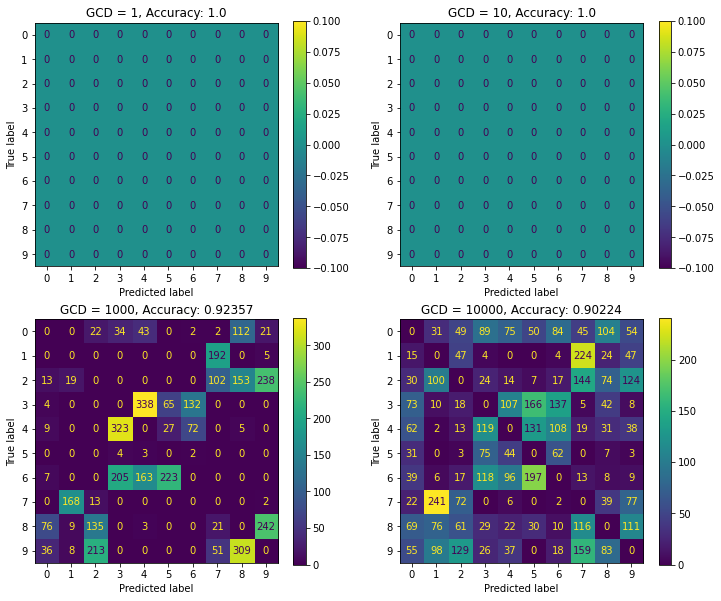

In [17]:
oof_preds, test_soft, test_hard = score_model(
    Resampler(
        test_samples = False
    )
)

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('resample_train_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('resample_train_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])

## Sample Using Test Data


Fold 0: 0.95688 accuracy in 252.1s.
Fold 1: 0.95479 accuracy in 250.39s.
Fold 2: 0.95745 accuracy in 252.13s.
Fold 3: 0.954 accuracy in 251.48s.
Fold 4: 0.95831 accuracy in 241.05s.
Fold 5: 0.95699 accuracy in 242.31s.
Fold 6: 0.95829 accuracy in 247.04s.
Fold 7: 0.96121 accuracy in 261.64s.
Fold 8: 0.95825 accuracy in 265.25s.
Fold 9: 0.95571 accuracy in 252.21s.

Average Accuracy: 0.95719


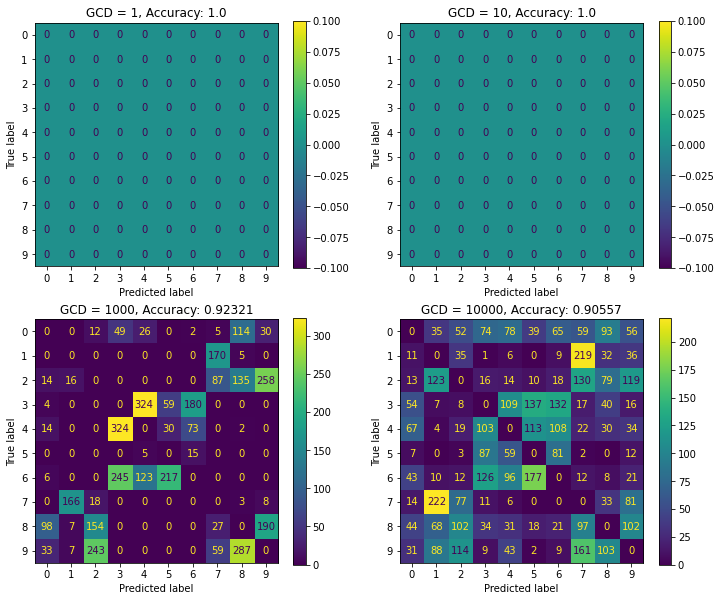

In [18]:
oof_preds, test_soft, test_hard = score_model(
    Resampler(
        test_samples = True
    )
)

# Submission (Hard Voting)
submission['target'] = encoder.inverse_transform(test_hard)
submission.to_csv('resample_test_hardvoting_submission.csv', index=False)

# Submission (Soft Voting)
submission['target'] = encoder.inverse_transform(test_soft)
submission.to_csv('resample_test_softvoting_submission.csv', index=False)

# Confusion Matrix
plot_confusion_matrix(train['target'], oof_preds, train['gcd'], train['sample_weight'])